Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734257117.155617      90 service.cc:145] XLA service 0x7c61e0007630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734257117.155697      90 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   1/1825 ━━━━━━━━━━━━━━━━━━━━ 12:49:56 25s/step - accuracy: 0.0000e+00 - loss: 7.3658 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1734257133.671598      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.0035 - loss: 7.0637 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 1: val_loss improved from inf to 5.85454, saving model to vgg19_checkpoint_epoch-01_val_loss-5.85.weights.h5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 1135s 608ms/step - accuracy: 0.0035 - loss: 7.0636 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0380 - val_loss: 5.8545 - val_precision: 1.0000 - val_recall: 5.0000e-04 - learning_rate: 1.0000e-05
Epoch 2/30
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.0143 - loss: 6.4344 - precision: 0.1109 - recall: 1.3539e-04
Epoch 2: val_loss improved from 5.85454 to 5.12688, saving model to vgg19_checkpoint_epoch-02_val_loss-5.13.weights.h5
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 747s 407ms/step - accuracy: 0.0143 - loss: 6.4343 - precision: 0.1110 - recall: 1.3549e-04 - val_accuracy: 0.1255 - val_loss: 5.1269 - val_precision: 0.7000 - val_recall: 0.0105 - learning_rate: 1.0000e-05
Epoch 3/30
1825/1825 ━━━━━━━

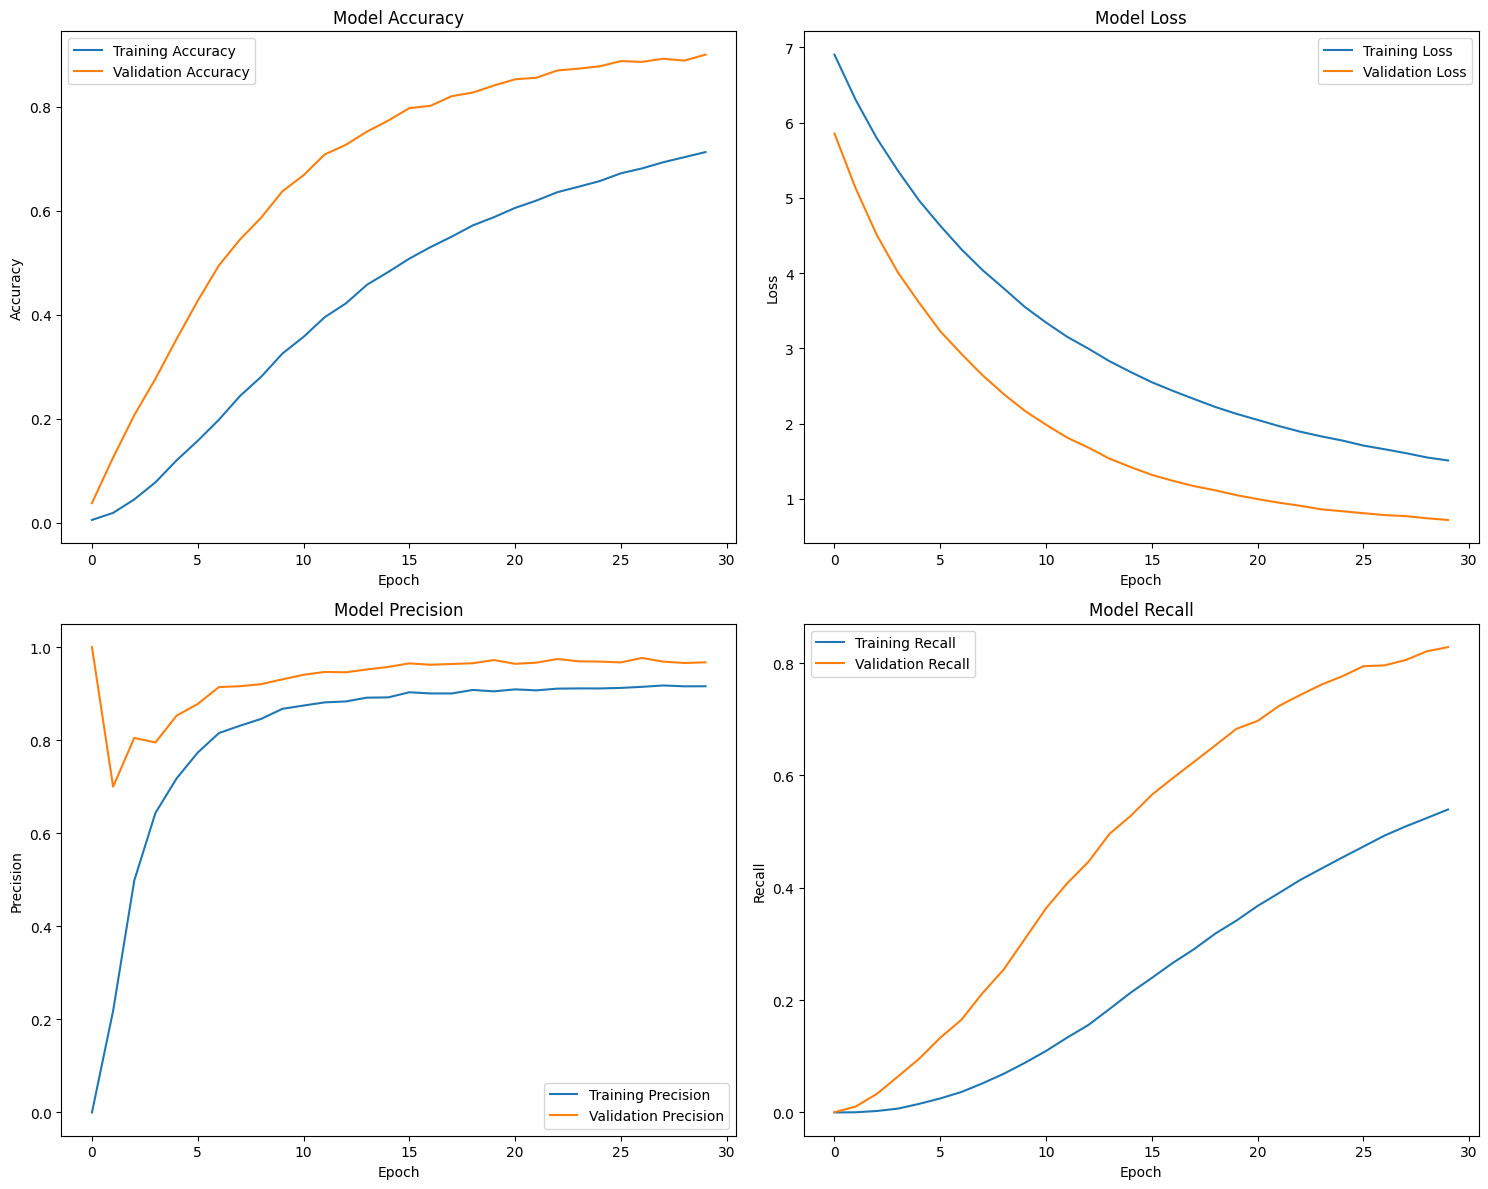

In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import (confusion_matrix, precision_recall_fscore_support, 
                           average_precision_score, precision_recall_curve)
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Add mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Set paths
BASE_PATH = '/kaggle/input/400birds/400BirdSpecies'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VALID_PATH = os.path.join(BASE_PATH, 'valid')
TEST_PATH = os.path.join(BASE_PATH, 'test')

# Enhanced data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

n_classes = len(train_generator.class_indices)

# Create model
base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze early layers
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Reduced dense layer sizes
x = Dense(1024, activation='relu',  # Changed from 2048
          kernel_initializer='he_normal',  # Added initialization
          kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)  # Reduced regularization
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu',  # Changed from 1024
          kernel_initializer='he_normal',
          kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model with additional metrics
model.compile(
    optimizer=Adam(learning_rate=0.00001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()]
)

# Callbacks
checkpoint = ModelCheckpoint(
    filepath='vgg19_checkpoint_epoch-{epoch:02d}_val_loss-{val_loss:.2f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)

# Training
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Enhanced evaluation functions
def plot_metrics(history):
    # Print available metrics to debug
    print("Available metrics:", history.history.keys())
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    # Precision plot
    ax3.plot(history.history['precision'], label='Training Precision')
    ax3.plot(history.history['val_precision'], label='Validation Precision')
    ax3.set_title('Model Precision')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Precision')
    ax3.legend()
    
    # Recall plot
    ax4.plot(history.history['recall'], label='Training Recall')
    ax4.plot(history.history['val_recall'], label='Validation Recall')
    ax4.set_title('Model Recall')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Recall')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

# Evaluate the model and display metrics
plot_metrics(history)
